In [23]:
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.datasets import ImageFolder
from PIL import Image

In [24]:
data_root = '/content/drive/MyDrive/컴퓨터비전 시즌2/5. 컴퓨터 비전/Data/4'

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
def display_images(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

In [27]:
categories = ['Train crack', 'Train normal', 'Val crack', 'Val normal', 'Test crack', 'Test normal']

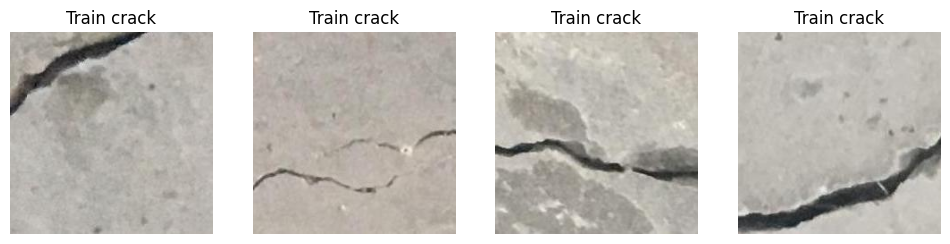

Train crack 총 이미지 수: 17650


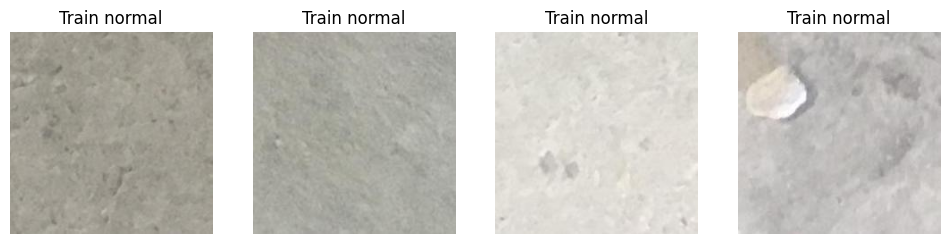

Train normal 총 이미지 수: 17899


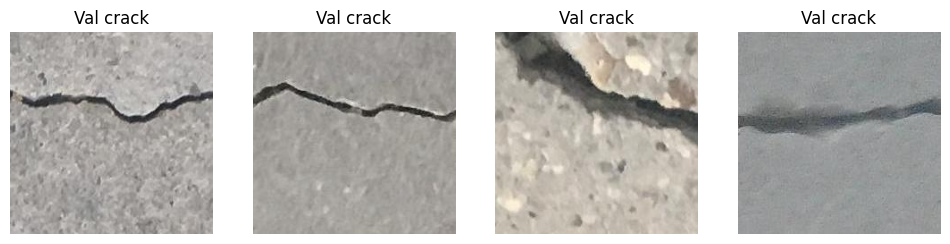

Val crack 총 이미지 수: 1600


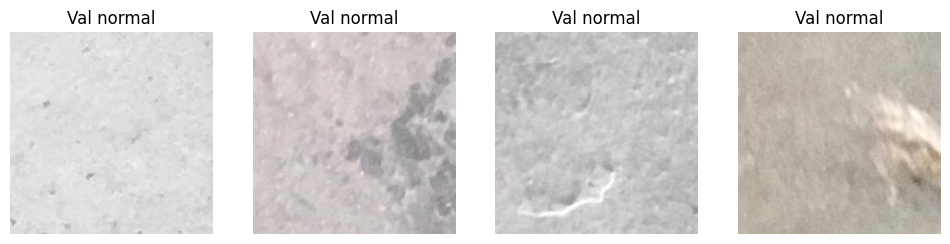

Val normal 총 이미지 수: 1700


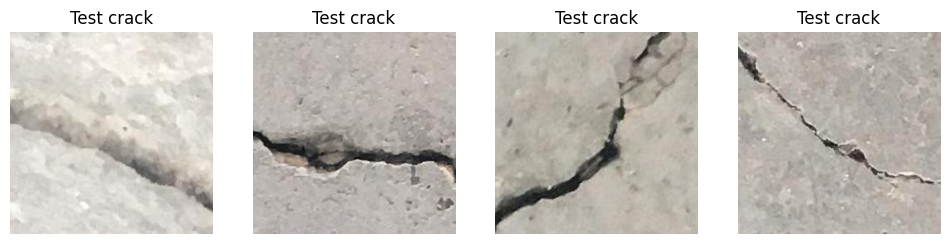

Test crack 총 이미지 수: 100


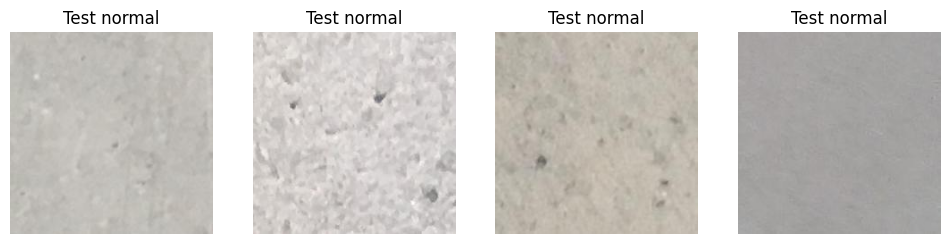

Test normal 총 이미지 수: 100


In [28]:
for category in categories:
    image_paths = glob.glob(f'{data_root}/{category.lower().replace(" ", "/")}/*')
    # print(image_paths)
    display_images(image_paths, category)
    print(f'{category} 총 이미지 수: {len(image_paths)}')

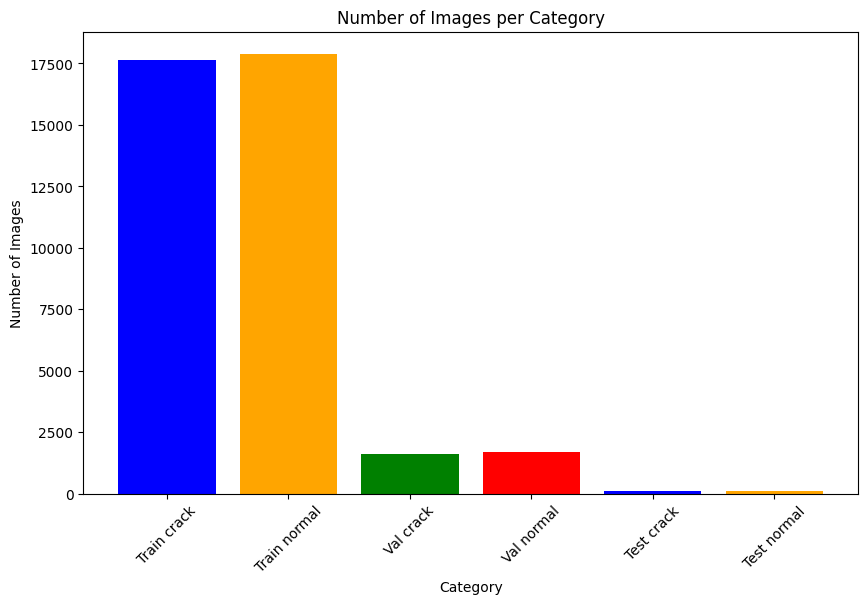

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'{data_root}/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [30]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [31]:
train_dataset = ImageFolder(f'{data_root}/train', transform=transform)
val_dataset = ImageFolder(f'{data_root}/val', transform=transform)

In [32]:
num_of_train = 34550
num_of_val = 3300
train_indices = list(range(num_of_train))
val_indices = list(range(num_of_val))

In [33]:
# 학습데이터 수가 많아 무작위 샘플 200개 선택
np.random.shuffle(train_indices)
train_subset_indices = train_indices[:200]

np.random.shuffle(val_indices)
val_subset_indices = val_indices[:20]

In [34]:
train_loader = DataLoader(dataset=train_dataset, batch_size=8, sampler=train_subset_indices)
val_loader = DataLoader(dataset=val_dataset, batch_size=8, sampler=val_subset_indices)

In [35]:
model = models.vgg19(pretrained=True)
model = model.to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### vgg19(Visual Geometry Group 19)
* 2014년 옥스포드 대학교 연구팀이 개발한 모델 중 하나로, 대회에서 높은 성능을 보여주며 유명
* 주로 이미지 분류, 물체 검출, 이미지 특징 추출 등의 작업에 사용
* 19개의 층을 가지고 있어서 VGG19라고 부르며, 구조는 간단하지만 깊이가 깊어 이미지 분류 작업에서 우수한 성능을 발휘
* 총 16개의 컨볼루션 층이 있으며, 모든 컨볼루션 필터의 크기는 3*3
* 마지막에는 세 개의 FC 레이어가 있고, softmax 함수로 연결되어 1000개의 클래스를 예측

<img src='https://miro.medium.com/v2/resize:fit:1192/1*Q_bg1E3trWcjdk9_jnVGwg.png'>

In [36]:
for param in model.parameters():
    param.requires_grad = False

In [37]:
model.classifier[6] = nn.Linear(4096, 2)
model.classifier[6].requires_grad = True
model.classifier[6] = model.classifier[6].to(device)

In [38]:
loss_func = nn.CrossEntropyLoss()

### Adam vs RAdam
* Adam
    * 학습률이 각 파라미터에 대해 다르게 조정
    * 각 파라미터의 변화량을 바탕으로 학습률을 조정하기 때문에 빠르게 수렴할 수 있음
    * 첫 번째 모멘텀 추정치(평균)와 두 번째 모멘텀 추정치(분산)을 사용
    * 해당 추정치는 파라미터의 업데이트 방향과 크기를 조정
* RAdam
    * Adam의 변형 버전
    * Adam의 장점을 유지하면서 학습 초기에 안정성을 높이기 위해 개선
    * 초기 학습률을 조정하는 방식에서 Adam의 바이어스 보정 단계를 수정하여 학습 초기 단계의 안정성을 높임(초기 학습률을 빠르게 조정하는 문제를 완화)
    * 학습 초기에 학습률을 낮추고 일정 시점 이후에는 Adam과 비슷하게 학습률을 조정

In [39]:
def train_model(optim_name, model, train_loader, val_loader, loss_func, num_epochs=20):
    if optim_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    elif optim_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    elif optim_name == 'RAdam':
        optimizer = optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    else:
        raise ValueError(f'Unsupported optimizer: {optim_name}')

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = loss_func(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'[{optim_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [40]:
train_losses_SGD, val_losses_SGD, val_accuracies_SGD = train_model(
    'SGD', model, train_loader, val_loader, loss_func
)

[SGD] Epoch 1, Train Loss: 0.504404, Val Loss: 0.241249, Val Accuracy: 100.00%
[SGD] Epoch 2, Train Loss: 0.211053, Val Loss: 0.165165, Val Accuracy: 100.00%
[SGD] Epoch 3, Train Loss: 0.164139, Val Loss: 0.113509, Val Accuracy: 100.00%
[SGD] Epoch 4, Train Loss: 0.144550, Val Loss: 0.084430, Val Accuracy: 100.00%
[SGD] Epoch 5, Train Loss: 0.134270, Val Loss: 0.072515, Val Accuracy: 100.00%
[SGD] Epoch 6, Train Loss: 0.142822, Val Loss: 0.082449, Val Accuracy: 100.00%
[SGD] Epoch 7, Train Loss: 0.136826, Val Loss: 0.073245, Val Accuracy: 100.00%
[SGD] Epoch 8, Train Loss: 0.105844, Val Loss: 0.067202, Val Accuracy: 100.00%
[SGD] Epoch 9, Train Loss: 0.090829, Val Loss: 0.056308, Val Accuracy: 100.00%
[SGD] Epoch 10, Train Loss: 0.114045, Val Loss: 0.055961, Val Accuracy: 100.00%
[SGD] Epoch 11, Train Loss: 0.124162, Val Loss: 0.050096, Val Accuracy: 100.00%
[SGD] Epoch 12, Train Loss: 0.123447, Val Loss: 0.046003, Val Accuracy: 100.00%
[SGD] Epoch 13, Train Loss: 0.093133, Val Loss: 0

In [42]:
# 초기화
model = models.vgg19(pretrained=True)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, 2)
model.classifier[6].requires_grad = True
model.classifier[6] = model.classifier[6].to(device)

In [43]:
train_losses_Adam, val_losses_Adam, val_accuracies_Adam = train_model(
    'Adam', model, train_loader, val_loader, loss_func
)

[Adam] Epoch 1, Train Loss: 0.485992, Val Loss: 0.317261, Val Accuracy: 85.00%
[Adam] Epoch 2, Train Loss: 0.212046, Val Loss: 0.161004, Val Accuracy: 100.00%
[Adam] Epoch 3, Train Loss: 0.160990, Val Loss: 0.100956, Val Accuracy: 100.00%
[Adam] Epoch 4, Train Loss: 0.136480, Val Loss: 0.093030, Val Accuracy: 100.00%
[Adam] Epoch 5, Train Loss: 0.134833, Val Loss: 0.077620, Val Accuracy: 100.00%
[Adam] Epoch 6, Train Loss: 0.109814, Val Loss: 0.069129, Val Accuracy: 100.00%
[Adam] Epoch 7, Train Loss: 0.109322, Val Loss: 0.051366, Val Accuracy: 100.00%
[Adam] Epoch 8, Train Loss: 0.115637, Val Loss: 0.048371, Val Accuracy: 100.00%
[Adam] Epoch 9, Train Loss: 0.089364, Val Loss: 0.050585, Val Accuracy: 100.00%
[Adam] Epoch 10, Train Loss: 0.077650, Val Loss: 0.040568, Val Accuracy: 100.00%
[Adam] Epoch 11, Train Loss: 0.091009, Val Loss: 0.037845, Val Accuracy: 100.00%
[Adam] Epoch 12, Train Loss: 0.081384, Val Loss: 0.038329, Val Accuracy: 100.00%
[Adam] Epoch 13, Train Loss: 0.066213,

In [45]:
# 초기화
model = models.vgg19(pretrained=True)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, 2)
model.classifier[6].requires_grad = True
model.classifier[6] = model.classifier[6].to(device)

In [46]:
train_losses_RAdam, val_losses_RAdam, val_accuracies_RAdam = train_model(
    'RAdam', model, train_loader, val_loader, loss_func
)

[RAdam] Epoch 1, Train Loss: 0.672562, Val Loss: 0.623766, Val Accuracy: 80.00%
[RAdam] Epoch 2, Train Loss: 0.570254, Val Loss: 0.521402, Val Accuracy: 95.00%
[RAdam] Epoch 3, Train Loss: 0.472776, Val Loss: 0.425184, Val Accuracy: 95.00%
[RAdam] Epoch 4, Train Loss: 0.383576, Val Loss: 0.350475, Val Accuracy: 100.00%
[RAdam] Epoch 5, Train Loss: 0.311403, Val Loss: 0.293455, Val Accuracy: 100.00%
[RAdam] Epoch 6, Train Loss: 0.277875, Val Loss: 0.253209, Val Accuracy: 100.00%
[RAdam] Epoch 7, Train Loss: 0.242480, Val Loss: 0.218037, Val Accuracy: 100.00%
[RAdam] Epoch 8, Train Loss: 0.219061, Val Loss: 0.191350, Val Accuracy: 100.00%
[RAdam] Epoch 9, Train Loss: 0.182018, Val Loss: 0.168562, Val Accuracy: 100.00%
[RAdam] Epoch 10, Train Loss: 0.173046, Val Loss: 0.155222, Val Accuracy: 100.00%
[RAdam] Epoch 11, Train Loss: 0.176165, Val Loss: 0.144455, Val Accuracy: 100.00%
[RAdam] Epoch 12, Train Loss: 0.154061, Val Loss: 0.131046, Val Accuracy: 100.00%
[RAdam] Epoch 13, Train Loss

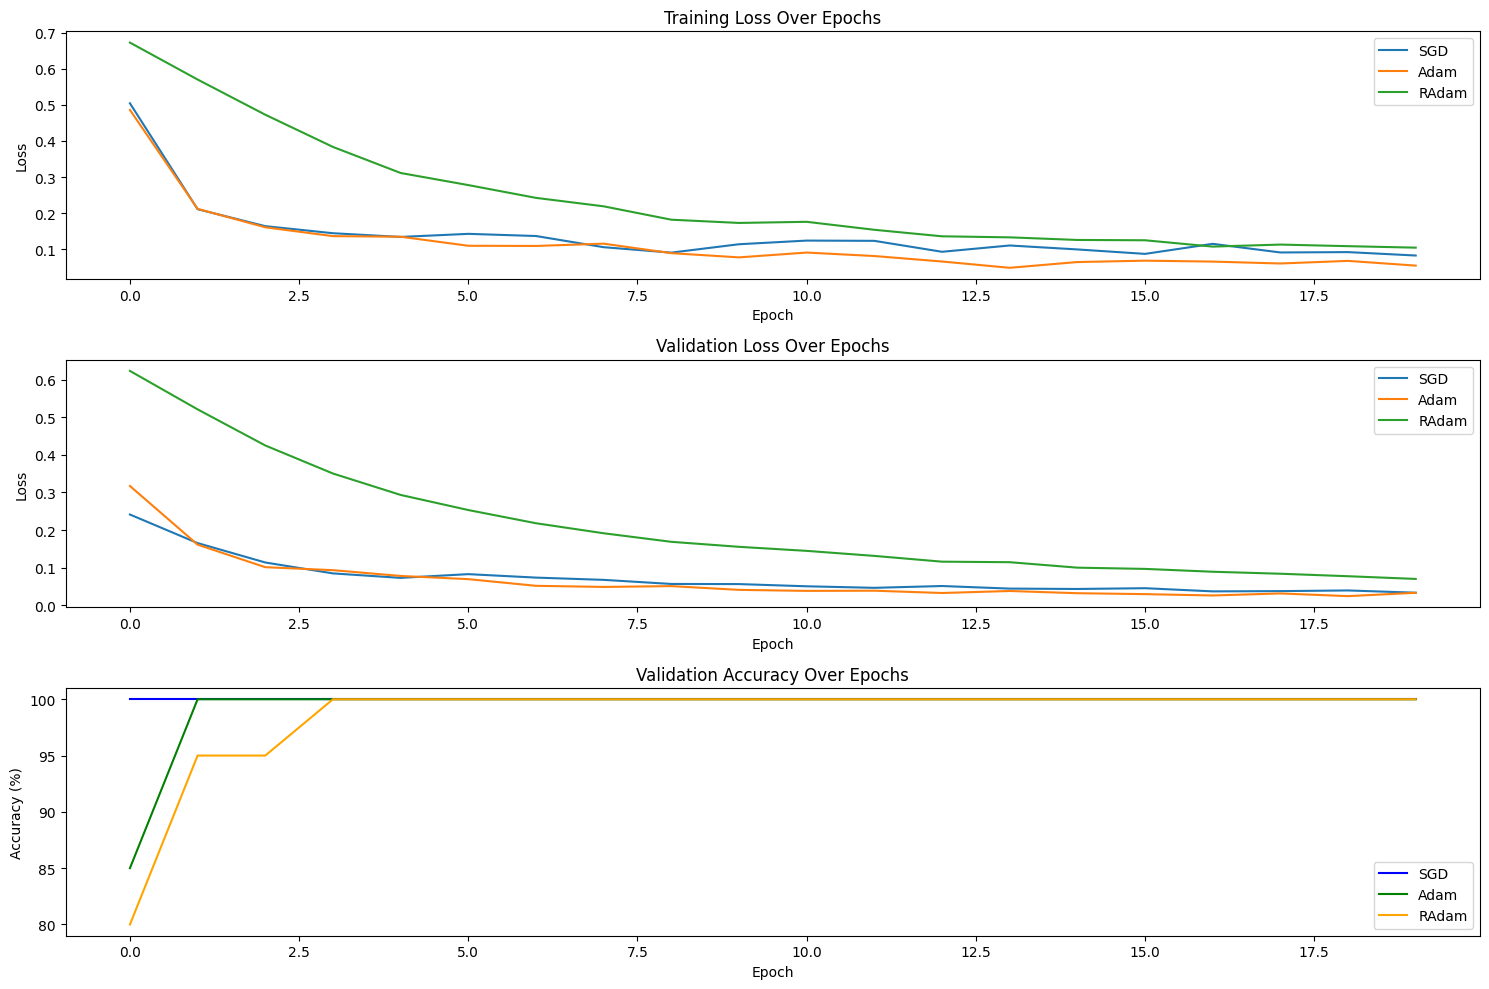

In [47]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_SGD, label='SGD')
plt.plot(train_losses_Adam, label='Adam')
plt.plot(train_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_SGD, label='SGD')
plt.plot(val_losses_Adam, label='Adam')
plt.plot(val_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_SGD, label='SGD', color='blue')
plt.plot(val_accuracies_Adam, label='Adam', color='green')
plt.plot(val_accuracies_RAdam, label='RAdam', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

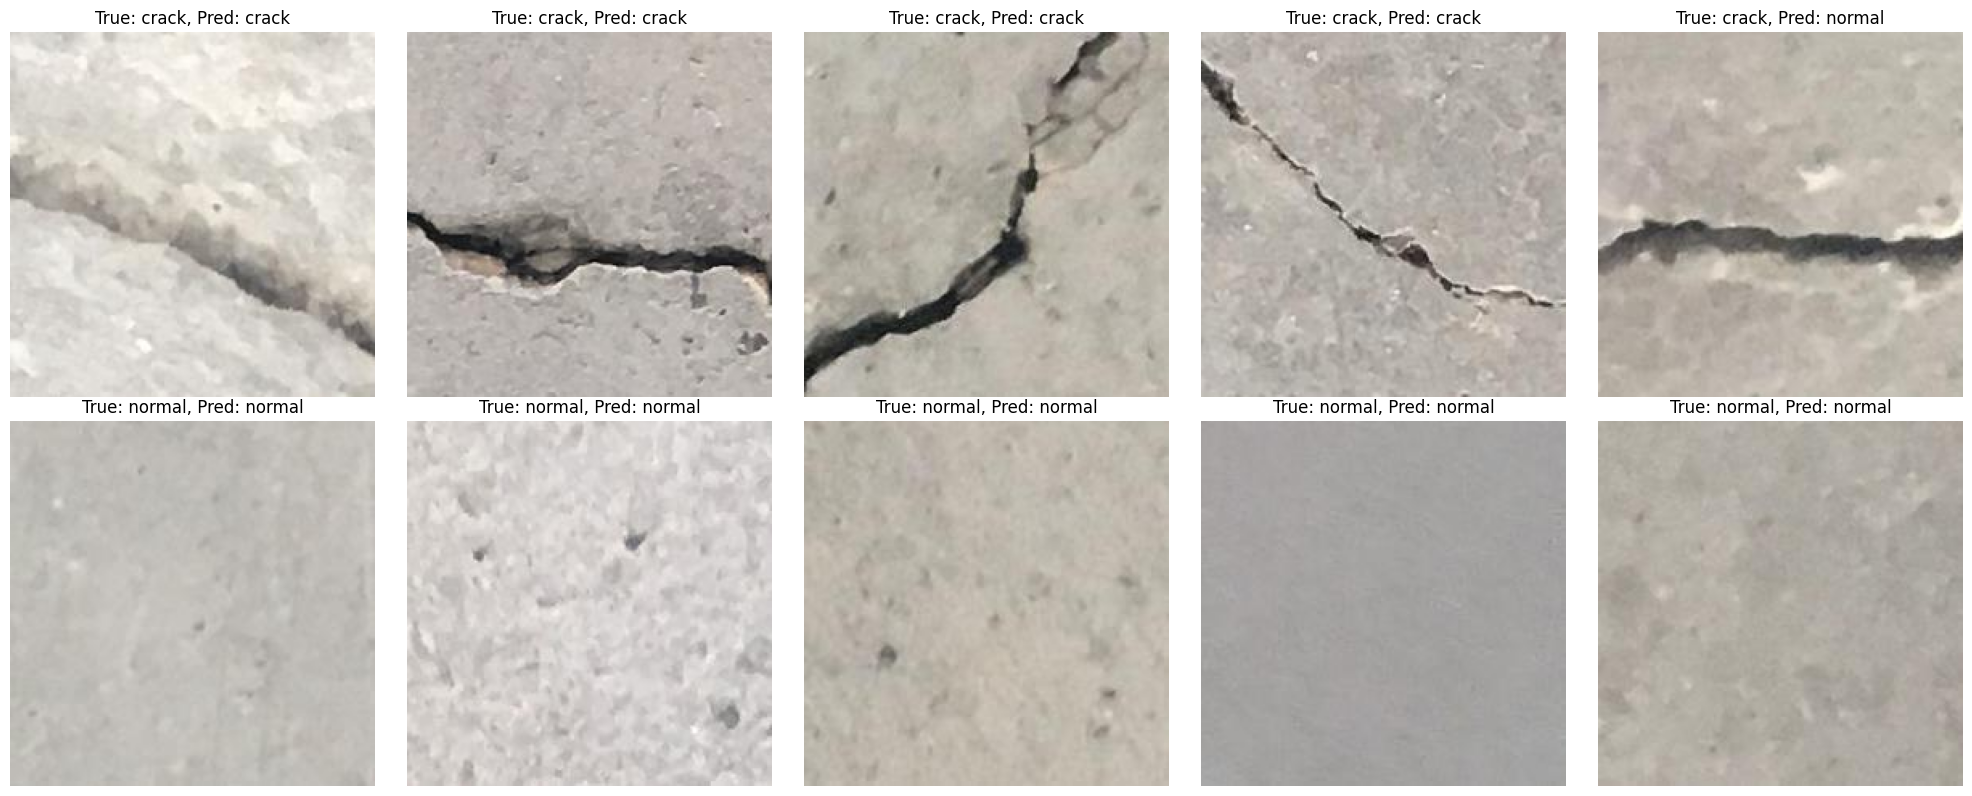

In [49]:
class_folders = {
    'crack': f'{data_root}/test/crack',
    'normal': f'{data_root}/test/normal'
}

plt.figure(figsize=(20, 8))

counter = 1

for class_name, folder_path in class_folders.items():
    image_paths = glob.glob(os.path.join(folder_path, "*"))
    selected_paths = image_paths[:5]

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)
        image = image.to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
        prediction = 'crack' if predicted.item() == 0 else 'normal'

        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1

plt.tight_layout()
plt.show()